# Data Story: TED Events

This assignment uses the cleaned dataset for my first capstone project: TED Talk Predictions. The dataset contains information on 2,344 TED Talk videos available on TED.com. It includes only talks from offical TED events with transcripts at least 1000 characters long that are no more than 25 minutes (see 'TED Cleaning.ipynb' for more information). Using the 330 columns of data, I would like to explore a scenario: 

__You've been given tickets, airfare, and housing to attend _any_ TED event. Congraulations! But you don't know much about them and you don't know which one to choose. Bummer.__

__Thankfully, however, you know somebody who can comb the TED archives and give you information about many past TED Talks and have this guide to help you choose based on your interests. Let's see what we've got!__

TED is an acronym for Technology, Education, and Design. This non-profit seeks to share ideas and start conversations and does so through conferences all over the world, multiple times a year. There have been hundreds of different TED events since their inception in the '80s and these events can be broken into (sometimes artificial, but useful) groups based on their names and focuses:
<ul>
    <li>__TED Yearly__: This is the main event, located somewhere in North America every year.
    <li>__TED Global__: The focus and location for this event are international.
    <li>__TEDx__: These independently-organized events are not "TED," strictly speaking, but share the name and vision of the organization.
    <li>__TED@__: Every year, TED partners with a set of businesses and puts on an event, such as TED@UPS or TED@Intel, with speakers from those companies.
    <li>__TED Women__: These events focus on women's abilities to be and create change in the world.
    <li>__TED Salon__: Instead of a full-on TED event, these events last just an evening.
    <li>__TEDMED__: A focus on health and healthcare from all alngles make these yearly events unique.
    <li>__Other__: There have been plenty of one-off events all over the world with many different focuses. This is the catch-all category for any event or type of event with less than 50 videos in the TED archives.
</ul>
With these kinds of events in mind, let's take a look at what events have the most:

1. Positive topics (sentiment)
2. Music or Dance
3. Positively-rated talks
4. Short talks
5. Talks with more than one speaker

We first need to import our data and relevant packages:

In [244]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import nltk

with open('TED_cleaned.pickle', 'rb') as file:
    df = pickle.load(file)
    
# combine Summit, Mission Blue, TED Live, and TED Youth with Other
def event_switch(x):
    other = ['TED Youth', 'TED Live', 'Mission Blue', 'Summit']
    if x in other:
        return 'Other'
    else:
        return x
    
df['event_type'] = df['event_type'].apply(event_switch)

## 1. Which events have the most positive talks?

This is a double-sided question. We'll first run sentiment analysis on each talk. This analysis looks at each word in a document and rates how "positive" or "negative" the word is with a number between -1 and 1. The mean of the non-zero scores represents the "sentiment" of the talk as a whole. Ideally, a talk about sunshine, rainbows, and puppies would have a "sentiment" score of about 0.99 and one about the Eeore's awful vacation to visit the Grim Reaper would score -0.99. In reality, these scores help us estimate if a talk is light and entertaining (+1) or somber and reflective (-1).

For the two sides of the question, we will look at both the events with the highest average positive score _and_ the events with the highest percentage of talks with a positive rating.

In [245]:
# sentiment analysis
df.loc[:, 'sent_overall'] = df.loc[:, 'transcript'].apply(lambda x: TextBlob(x).sentiment.polarity)

Let's take a look at a boxplot of our scores to see how they compare:

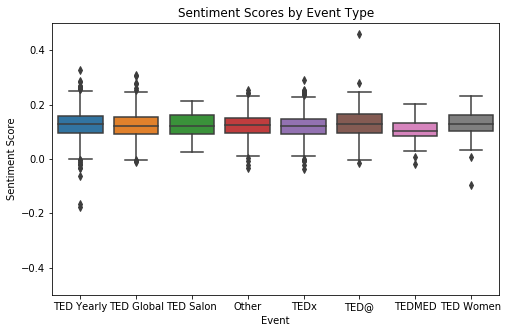

In [246]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
_ = sns.boxplot(y='sent_overall', x='event_type', data=df, orient='v')
_ = plt.ylim((-0.5, 0.5))
_ = plt.title("Sentiment Scores by Event Type")
_ = plt.xlabel("Event")
_ = plt.ylabel("Sentiment Score")
_ = plt.show()

We can see that overall, the trend is positive, but it's impossible to tell how they should be ordered. Let's take a look at the numbers to make our decision. We'll also calculate which events have the most positive talks by count as well:

In [247]:
sents = df['sent_overall'].groupby(df['event_type']).mean().sort_values(ascending=False)

print("Top 3 events by mean sentiment score:")
print("1. {0}: {1}".format(sents.keys()[0], round(sents.iloc[0], 5)))
print("2. {0}: {1}".format(sents.keys()[1], round(sents.iloc[1], 5)))
print("3. {0}: {1}\n".format(sents.keys()[2], round(sents.iloc[2], 5)))

# positive counter
def pos_count(x):
    counter = 0
    for i in x:
        if i > 0:
            counter += 1
    return counter

event_counts = df['event_type'].value_counts()
positive_counts = df['sent_overall'].groupby(df['event_type']).apply(pos_count)
event_pcts = (positive_counts / event_counts).sort_values(ascending=False)

print("Top 3 events by percent of talks with a positive score:")
print("1. {0}: {1}%".format(event_pcts.keys()[0], round(event_pcts.iloc[0]*100, 2)))
print("2. {0}: {1}%".format(event_pcts.keys()[1], round(event_pcts.iloc[1]*100, 2)))
print("3. {0}: {1}%".format(event_pcts.keys()[2], round(event_pcts.iloc[2]*100, 2)))

Top 3 events by mean sentiment score:
1. TED@: 0.12804
2. TED Women: 0.12802
3. TED Yearly: 0.12678

Top 3 events by percent of talks with a positive score:
1. TED Salon: 100.0%
2. TED Global: 99.12%
3. TED Women: 98.94%


## 2. Which events have the most music and dance?

If talks really aren't your jam, but you still want to look hip and thoughtful, maybe you just want the event with the greatest chance of a talk being (or being about) music or dance.

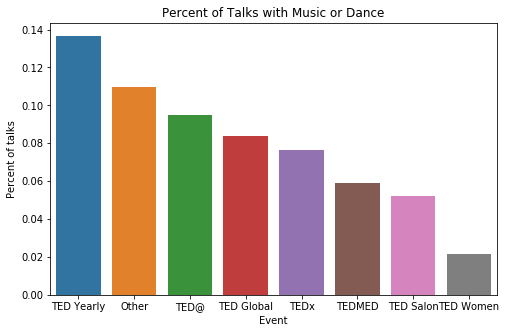

Top 3 events most likely to have music or dance:
1. TED Yearly: 13.66%
2. Other: 10.97%
3. TED@: 9.49%


In [248]:
df['music_dance'] = df['has_music'] | df['has_note'] | df['has_dance']
md = df['music_dance'].groupby(df['event_type'])
md_pcts = md.apply(lambda x: sum(x)/len(x)).sort_values(ascending=False)

_ = fig, ax = plt.subplots()
_ = fig.set_size_inches(8, 5)
_ = sns.barplot(y='music_dance', x='event_type', data=df, order=list(md_pcts.keys()), ci=None)
_ = plt.ylabel('Percent of talks')
_ = plt.xlabel('Event')
_ = plt.title('Percent of Talks with Music or Dance')
_ = plt.show()

print("Top 3 events most likely to have music or dance:")
print("1. {0}: {1}%".format(md_pcts.keys()[0], round(md_pcts.iloc[0]*100, 2)))
print("2. {0}: {1}%".format(md_pcts.keys()[1], round(md_pcts.iloc[1]*100, 2)))
print("3. {0}: {1}%".format(md_pcts.keys()[2], round(md_pcts.iloc[2]*100, 2)))

## 3. Which events have the most positively-rated talks?

Maybe you want to go to an event where most of the talks are looked upon favorably viewers. After watching a video on TED.com, users can rate a video positively or negatively. These scores represent the average percent of positive ratings for each category.

Keep in mind, the talks that are chosen to appear on TED.com are the best of the best and don't necessarily represent all the talks. You can, however, get a sense of how good the talks can get.

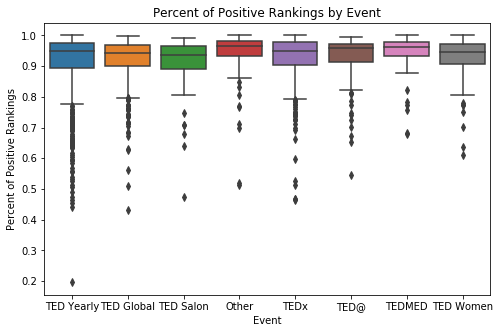

Top 3 events by median percent of positive ratings:
1. Other: 96.51%
2. TEDMED: 96.05%
3. TED@: 95.81%


In [252]:
pos_pcts = df['pos_pct'].groupby(df['event_type']).apply(np.median).sort_values(ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
_ = sns.boxplot(y='pos_pct', x='event_type', data=df, orient='v')
_ = plt.title("Percent of Positive Rankings by Event")
_ = plt.xlabel("Event")
_ = plt.ylabel("Percent of Positive Rankings")
_ = plt.show()

print("Top 3 events by median percent of positive ratings:")
print("1. {0}: {1}%".format(pos_pcts.keys()[0], round(pos_pcts.iloc[0]*100, 2)))
print("2. {0}: {1}%".format(pos_pcts.keys()[1], round(pos_pcts.iloc[1]*100, 2)))
print("3. {0}: {1}%".format(pos_pcts.keys()[2], round(pos_pcts.iloc[2]*100, 2)))

## 4. Which events have the shortest and longest average talks?

TED talks are supposed to run 18 minutes. But sometimes people go (way) over and sometimes they don't hit the half way mark! Depending on your preferences, you may want a different TED experience. Let's take a look at the top 3 in either direction:

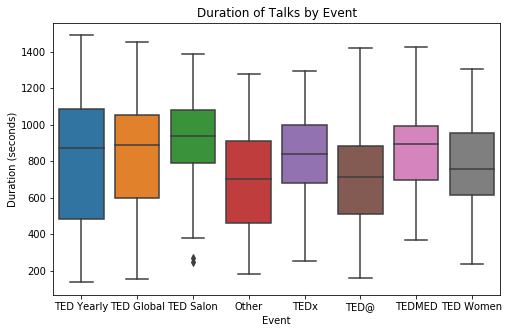

Top 3 events by longest average talk:
1. TED Salon: 15 minutes, 7 seconds
2. TEDMED: 14 minutes, 365 seconds
3. TEDx: 13 minutes, 538 seconds

Top 3 events by shortest average talk:
1. Other: 11 minutes, 408 seconds
2. TED@: 11 minutes, 437 seconds
3. TED Women: 12 minutes, 570 seconds


In [250]:
lengths = df['duration'].groupby(df['event_type']).apply(np.mean).sort_values(ascending=False)

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
_ = sns.boxplot(y='duration', x='event_type', data=df, orient='v')
_ = plt.title("Duration of Talks by Event")
_ = plt.xlabel("Event")
_ = plt.ylabel("Duration (seconds)")
_ = plt.show()


print("Top 3 events by longest average talk:")
print("1. {0}: {1} minutes, {2} seconds".format(lengths.keys()[0], int(divmod(lengths.iloc[0], 60)[0]), int(divmod(lengths.iloc[0], 60)[1]*10)))
print("2. {0}: {1} minutes, {2} seconds".format(lengths.keys()[1], int(divmod(lengths.iloc[1], 60)[0]), int(divmod(lengths.iloc[1], 60)[1]*10)))
print("3. {0}: {1} minutes, {2} seconds\n".format(lengths.keys()[2], int(divmod(lengths.iloc[2], 60)[0]), int(divmod(lengths.iloc[2], 60)[1]*10)))

print("Top 3 events by shortest average talk:")
print("1. {0}: {1} minutes, {2} seconds".format(lengths.keys()[-1], int(divmod(lengths.iloc[-1], 60)[0]), int(divmod(lengths.iloc[-1], 60)[1]*10)))
print("2. {0}: {1} minutes, {2} seconds".format(lengths.keys()[-2], int(divmod(lengths.iloc[-2], 60)[0]), int(divmod(lengths.iloc[-2], 60)[1]*10)))
print("3. {0}: {1} minutes, {2} seconds".format(lengths.keys()[-3], int(divmod(lengths.iloc[-3], 60)[0]), int(divmod(lengths.iloc[-3], 60)[1]*10)))

## 5. Which events have the most talks with more than one speaker?

Maybe you love to see cooperation and interaction in TED talks. Let's take a look at the number of speakers in two ways. First, we'll look at the average number of speakers. Second, we'll look at the percent of talks with more than one speaker.

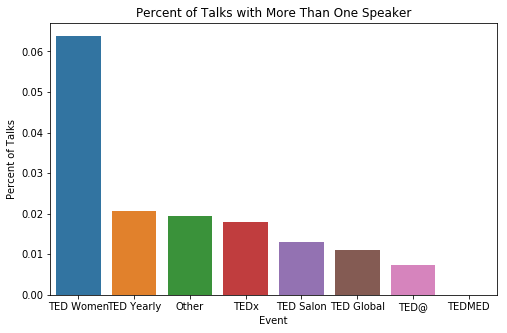

Top 3 events by mean number of speakers:
1. TED Women: 1.08511
2. TED Yearly: 1.02732
3. Other: 1.02581

Top 3 events by percent of talks with more than one speaker:
1. TED Women: 6.38%
2. TED Yearly: 2.08%
3. Other: 1.94%


In [251]:
speakers = df['num_speaker'].groupby(df['event_type']).mean().sort_values(ascending=False)

# +1 speaker counter
def one_count(x):
    counter = 0
    for i in x:
        if i > 1:
            counter += 1
    return counter

speaker_pct = df['num_speaker'].groupby(df['event_type']).apply(lambda x: one_count(x)/len(x)).sort_values(ascending=False)

df['speaker_one'] = df['num_speaker'].apply(lambda x: bool(x-1))

_ = fig, ax = plt.subplots()
_ = fig.set_size_inches(8, 5)
_ = sns.barplot(y='speaker_one', x='event_type', data=df, order=list(speaker_pct.keys()), ci=None)
_ = plt.ylabel('Percent of Talks')
_ = plt.xlabel('Event')
_ = plt.title('Percent of Talks with More Than One Speaker')
_ = plt.show()

print("Top 3 events by mean number of speakers:")
print("1. {0}: {1}".format(speakers.keys()[0], round(speakers.iloc[0], 5)))
print("2. {0}: {1}".format(speakers.keys()[1], round(speakers.iloc[1], 5)))
print("3. {0}: {1}\n".format(speakers.keys()[2], round(speakers.iloc[2], 5)))

print("Top 3 events by percent of talks with more than one speaker:")
print("1. {0}: {1}%".format(speaker_pct.keys()[0], round(speaker_pct.iloc[0]*100, 2)))
print("2. {0}: {1}%".format(speaker_pct.keys()[1], round(speaker_pct.iloc[1]*100, 2)))
print("3. {0}: {1}%".format(speaker_pct.keys()[2], round(speaker_pct.iloc[2]*100, 2)))

## Have a Good Trip!

Hopefully you're now better prepared to make your decision. Have a good trip!